# Prediciendo el ranking de una película nueva en IMDB

## Importamos librerias necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
import keras
import h5py
import PIL
import seaborn as sns

/home/nachofranco14/Documents/facultad/machine_learning/ds/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Levantamos los dataframes

In [3]:
#ds_title_akas = pd.read_csv('dataset_imdb/title.akas.tsv', sep='\t')  --> descartada
#ds_title_episode = pd.read_csv('dataset_imdb/title.episode.tsv', sep='\t')   --> descartada
#ds_name_basics =  pd.read_csv('dataset_imdb/name.basics.tsv', sep='\t') #--> descartada

ds_title_basics = pd.read_csv('dataset_imdb/title.basics.tsv', sep='\t')
ds_title_crew = pd.read_csv('dataset_imdb/title.crew.tsv', sep='\t') 
ds_title_principals = pd.read_csv('dataset_imdb/title.principals.tsv', sep='\t') 
ds_title_ratings = pd.read_csv('dataset_imdb/title.ratings.tsv', sep='\t')


#Acepta los archivos comprimidos
#ds_title_akas_gz = pd.read_csv('dataset_imdb/dataset_backup/title.akas.tsv.gz', sep='\t')

/home/nachofranco14/Documents/facultad/machine_learning/ds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

## Ahora necesitamos armar con todos, un solo dataframe


### Utilizando el método .merge() de Pandas

Reconociendo que todos los dataframes tienen la key que los relaciona, llamada 'tconst' (title const), lo utilizamos. Para Name Basics, utilizamos 'nconst' que es la key para el nombre

In [ ]:
ds_full = ds_title_basics.merge(ds_title_principals, left_on='tconst', right_on='tconst')
ds_full = ds_full.merge(ds_title_ratings, left_on='tconst', right_on='tconst')
ds_full = ds_full.merge(ds_title_crew, on='tconst')

# Exportamos el dataset completo a csv
ds_full.to_csv('ds_full.csv')

# Liberamos la memoria (~15.5GB en memoria)
del ds_title_basics
del ds_title_principals
del ds_title_ratings
del ds_title_crew
del ds_full

In [5]:
# Levantamos el dataset completo desde el csv creado (~3.5GB en memoria)
#ds_full = pd.read_csv('ds_full.csv')

# Para levantar el reducido
ds_full = pd.read_csv('ds_full_reducido.csv')
ds_full.head()

Unnamed: 0     tconst     primaryTitle originalTitle runtimeMinutes  \
0           0  tt0002130  Dante's Inferno     L'Inferno             68   
1           1  tt0002130  Dante's Inferno     L'Inferno             68   
2           2  tt0002130  Dante's Inferno     L'Inferno             68   
3           3  tt0002130  Dante's Inferno     L'Inferno             68   
4           4  tt0002130  Dante's Inferno     L'Inferno             68   

                    genres     nconst             category  averageRating  \
0  Adventure,Drama,Fantasy  nm1376180  production_designer            7.1   
1  Adventure,Drama,Fantasy  nm0660139                actor            7.1   
2  Adventure,Drama,Fantasy  nm0685283                actor            7.1   
3  Adventure,Drama,Fantasy  nm0209738                actor            7.1   
4  Adventure,Drama,Fantasy  nm3942815                actor            7.1   

   numVotes                      directors    writers  
0      1611  nm0078205,nm0655824,nm0209738  nm0019604  
1      1611  nm0078205,nm0655824,nm0209738  nm0019604  
2      1611  nm0078205,nm0655824,nm0209738  nm0019604  
3      1611  nm0078205,nm0655824,nm0209738  nm0019604  
4      1611  nm0078205,nm0655824,nm0209738  nm0019604

In [6]:
ds_full = ds_full.drop(columns=['Unnamed: 0', 'averageRating'])

#### Solo vamos a usar este dataframe cuando necesitemos averiguar el id de un actor

In [3]:
ds_name_basics =  pd.read_csv('dataset_imdb/name.basics.tsv', sep='\t')

In [6]:
ds_name_basics.head()


nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0045537,tt0043044,tt0072308,tt0050419  
1              actress,soundtrack  tt0037382,tt0117057,tt0040506,tt0038355  
2     actress,soundtrack,producer  tt0049189,tt0054452,tt0059956,tt0057345  
3         actor,writer,soundtrack  tt0077975,tt0072562,tt0080455,tt0078723  
4           writer,director,actor  tt0060827,tt0083922,tt0050976,tt0050986

### Hacemos una vista rápida de lo que tiene nuestro dataset completo

In [5]:
ds_full.describe()

Unnamed: 0       isAdult      ordering  averageRating      numVotes
count  7.022936e+06  7.022936e+06  7.022936e+06   7.022936e+06  7.022936e+06
mean   3.511468e+06  2.407141e-02  5.144578e+00   6.924606e+00  1.156190e+03
std    2.027347e+06  2.382536e+00  2.826665e+00   1.361124e+00  1.672823e+04
min    0.000000e+00  0.000000e+00  1.000000e+00   1.000000e+00  5.000000e+00
25%    1.755734e+06  0.000000e+00  3.000000e+00   6.200000e+00  9.000000e+00
50%    3.511468e+06  0.000000e+00  5.000000e+00   7.100000e+00  2.300000e+01
75%    5.267201e+06  0.000000e+00  8.000000e+00   7.900000e+00  9.700000e+01
max    7.022935e+06  1.993000e+03  1.000000e+01   1.000000e+01  1.954396e+06

De las variables numéricas encontramos que:
    - ordering lo vamos a sacar porque no nos interesa el orden que tiene en la tabla (quitar.1)
    - unnamed también (quitar.2)
    - isAdult es un booleano, pero se encuentra dentro de los géneros, por lo que no se tendrá en cuenta.
    - averageRating es nuestro valor a predecir
    - numVotes nos indica que hay el 75% de las peliculas fueron puntuadas 97 veces, lo que para este análisis sesgaría los resultados, al tener un número de votos tan fácilmente alcanzable.
    
    Definimos que trabajaremos solo con aquellas películas que hayan tenido más de 500 votos (algo más dificil de hacer 'mintiendo'). Analizaremos el estado del dataset acotado por esta situación a continuación, luego del análisis de las variables categóricas.

In [11]:
ds_full.describe(include='O')

tconst  titleType  primaryTitle originalTitle  startYear  endYear  \
count     7022936    7022936       7022936       7022936    7022936  7022936   
unique     823971         10        641884        650987        265       75   
top     tt1707384  tvEpisode  Episode #1.1  Episode #1.1       2012       \N   
freq           10    3056203         20124         20144     267174  6882187   

       runtimeMinutes   genres     nconst category      job characters  \
count         7022936  7022926    7022936  7022936  7022936    7022936   
unique            642     1906    1357321       12    20282     989232   
top                \N   Comedy  nm0170306    actor       \N         \N   
freq          1770624   690742       3121  1859484  5488286    3742532   

       directors  writers  
count    7022936  7022936  
unique    210998   372448  
top           \N       \N  
freq      686815  1085740

De las variables categóricas obtenemos que:
    - titleType tiene 10 valores diferentes, con lo cual podemos convertirlo en un One Hot Encoder (oneHotEncoder.1)
    - primaryTitle y originalTitle no podemos hacer nada, pero veremos si es viable tenerlos en cuenta. (quitar.6)
    - startYear y endYear veremos si los utilizamos o no, dado que para nuestras predicciones, usaremos siempre el año actual, por lo que desviaría lo aprendido. (quitar.3)
    - runtimeMinutes se tendrá en cuenta, es la duración del título. Controlaremos que las peliculas tengan una duración acorde (no sólo unos pocos minutos)
    - genres tiene 1906 valores, al analizarlo vemos que se trata de la lista de géneros que comprende el titulo, por lo que podríamos separarlo y crear un OneHotEncoder con esto. (oneHotEncoder.2)
    - nconst es el nombre de una persona relacionada al titulo, vemos que para todos los films, existen en total ~1.35M de personas
    - category muestra 12 valores únicos, en donde el más frecuente es 'actor', por lo que haremos de este campo un OneHotEncoder (oneHotEncoder.3)
    - job tiene muchos valores que dependen de la película, por lo que no es representativo para un análisis global (quitar.4)
    - characters al igual que job, depende de la película (al ser el nombre del personaje al que caracteriza un actor) por lo que no se tendrá en cuenta (quitar.5)
    - directors y writers son los nombres de las personas que fueron directores y escritores, respectivamente de la película. Se tendrán en cuenta y se combinarán con los one hot encoder de category, dado que habrá casos que no mencione al escritor o al director entre los principales de la película. (oneHotEncoder.4)
    
Definimos que para cada pelicula se crearán las columnas relacionadas a cada categoria y se pondrá el identificador de la persona en cada columna. 

In [3]:
# Para este ejemplo, debería quedar una sola row con todos 
# los datos de las personas en la categoría que trabajó
ds_full[ds_full['tconst'] == 'tt8443556']

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, tconst, titleType, primaryTitle, originalTitle, runtimeMinutes, genres, nconst, category, averageRating, numVotes, directors, writers]
Index: []

### Comenzamos realizando las actividades 'quitar'
Los campos que se decidieron quitar del dataset fueron ordering, unnamed, startYear, endYear, job, characters. (Indicados con la actividad 'quitar.{número}')

In [5]:
ds_full = ds_full.drop(columns=['Unnamed: 0', 'ordering','isAdult','startYear', 'endYear', 'job', 'characters'])

KeyError: "labels ['ordering' 'isAdult' 'startYear' 'endYear' 'job' 'characters'] not contained in axis"

### Continuamos realizando los One Hot Encoders decididos

#### titleType - One Hot Encoder 1 
#### No lo vamos a realizar, dado que vamos a analizar solo películas (category='movie'), por lo que nuestro dataset se reduce

In [6]:
ds_full = ds_full[(ds_full['titleType'] == 'movie') & (ds_full['numVotes'] > 500)]

ds_full.groupby(['tconst']).count()

Unnamed: 0  Unnamed: 0.1  titleType  primaryTitle  originalTitle  \
tconst                                                                        
tt0002130          10            10         10            10             10   
tt0002423          10            10         10            10             10   
tt0002844          10            10         10            10             10   
tt0003014          10            10         10            10             10   
tt0003037          10            10         10            10             10   
tt0003165           9             9          9             9              9   
tt0003419          10            10         10            10             10   
tt0003643          10            10         10            10             10   
tt0003740          10            10         10            10             10   
tt0003772          10            10         10            10             10   
tt0003930           9             9          9             9              9   
tt0003952          10            10         10            10             10   
tt0004026           6             6          6             6              6   
tt0004181          10            10         10            10             10   
tt0004465          10            10         10            10             10   
tt0004635           8             8          8             8              8   
tt0004707          10            10         10            10             10   
tt0004972          10            10         10            10             10   
tt0005060           9             9          9             9              9   
tt0005078           9             9          9             9              9   
tt0005339          10            10         10            10             10   
tt0005916           9             9          9             9              9   
tt0005960           9             9          9             9              9   
tt0006206          10            10         10            10             10   
tt0006333           9             9          9             9              9   
tt0006509          10            10         10            10             10   
tt0006731          10            10         10            10             10   
tt0006780           9             9          9             9              9   
tt0006826          10            10         10            10             10   
tt0006864          10            10         10            10             10   
...               ...           ...        ...           ...            ...   
tt7700730          10            10         10            10             10   
tt7705790           9             9          9             9              9   
tt7711342           9             9          9             9              9   
tt7717440          10            10         10            10             10   
tt7748244          10            10         10            10             10   
tt7748426           9             9          9             9              9   
tt7752454          10            10         10            10             10   
tt7762982          10            10         10            10             10   
tt7763020          10            10         10            10             10   
tt7784604          10            10         10            10             10   
tt7794524          10            10         10            10             10   
tt7797658          10            10         10            10             10   
tt7843946          10            10         10            10             10   
tt7853242          10            10         10            10             10   
tt7862330          10            10         10            10             10   
tt7871636          10            10         10            10             10   
tt7895904          10            10         10            10             10   
tt7912470           6             6          6             6 

In [27]:
ds_full[ds_full['titleType'] == 'movie'].groupby(['tconst']).count()

Unnamed: 0  titleType  primaryTitle  originalTitle  isAdult  \
tconst                                                                   
tt0000009           4          4             4              4        4   
tt0000147           7          7             7              7        7   
tt0000335           8          8             8              8        8   
tt0000574          10         10            10             10       10   
tt0000615           9          9             9              9        9   
tt0000630           4          4             4              4        4   
tt0000675           2          2             2              2        2   
tt0000676           4          4             4              4        4   
tt0000679           7          7             7              7        7   
tt0000739           2          2             2              2        2   
tt0000793           2          2             2              2        2   
tt0000862          10         10            10             10       10   
tt0000886           3          3             3              3        3   
tt0000891           4          4             4              4        4   
tt0000941           7          7             7              7        7   
tt0000992           1          1             1              1        1   
tt0001028           2          2             2              2        2   
tt0001049          10         10            10             10       10   
tt0001101           2          2             2              2        2   
tt0001112           4          4             4              4        4   
tt0001113           1          1             1              1        1   
tt0001115          10         10            10             10       10   
tt0001116          10         10            10             10       10   
tt0001122           7          7             7              7        7   
tt0001159           1          1             1              1        1   
tt0001175          10         10            10             10       10   
tt0001186           4          4             4              4        4   
tt0001230           1          1             1              1        1   
tt0001240          10         10            10             10       10   
tt0001258          10         10            10             10       10   
...               ...        ...           ...            ...      ...   
tt8375760           9          9             9              9        9   
tt8376598           6          6             6              6        6   
tt8376650           9          9             9              9        9   
tt8376990          10         10            10             10       10   
tt8377736          10         10            10             10       10   
tt8380458           6          6             6              6        6   
tt8386182          10         10            10             10       10   
tt8386446          10         10            10             10       10   
tt8387464          10         10            10             10       10   
tt8389906           4          4             4              4        4   
tt8390886          10         10            10             10       10   
tt8394576           4          4             4              4        4   
tt8395052           1          1             1              1        1   
tt8396188          10         10            10             10       10   
tt8396228          10         10            10             10       10   
tt8397524           7          7             7              7        7   
tt8399698           4          4             4              4        4   
tt8400800           3          3             3              3        3   
tt8403364          10         10            10             10       10   
tt8403396           9          9             9              9        9   
tt8404272           4          4             4              4        4   
tt8404588      

In [46]:
ds_full.groupby(['titleType']).count()

tconst  primaryTitle  originalTitle  isAdult  runtimeMinutes  \
titleType                                                                     
movie         1960681       1960681        1960681  1960681         1960681   
short          657767        657767         657767   657767          657767   
tvEpisode     3056203       3056203        3056203  3056203         3056203   
tvMiniSeries    65202         65202          65202    65202           65202   
tvMovie        373900        373900         373900   373900          373900   
tvSeries       453457        453457         453457   453457          453457   
tvShort         18565         18565          18565    18565           18565   
tvSpecial       50039         50039          50039    50039           50039   
video          336874        336874         336874   336874          336874   
videoGame       50248         50248          50248    50248           50248   

               genres   nconst  category  averageRating  numVotes  directors  \
titleType                                                                      
movie         1960681  1960681   1960681        1960681   1960681    1960681   
short          657767   657767    657767         657767    657767     657767   
tvEpisode     3056193  3056203   3056203        3056203   3056203    3056203   
tvMiniSeries    65202    65202     65202          65202     65202      65202   
tvMovie        373900   373900    373900         373900    373900     373900   
tvSeries       453457   453457    453457         453457    453457     453457   
tvShort         18565    18565     18565          18565     18565      18565   
tvSpecial       50039    50039     50039          50039     50039      50039   
video          336874   336874    336874         336874    336874     336874   
videoGame       50248    50248     50248          50248     50248      50248   

              writers  
titleType              
movie         1960681  
short          657767  
tvEpisode     3056203  
tvMiniSeries    65202  
tvMovie        373900  
tvSeries       453457  
tvShort         18565  
tvSpecial       50039  
video          336874  
videoGame       50248

In [6]:
ds_title_principals

tconst  ordering     nconst             category  \
0         tt0000001         1  nm1588970                 self   
1         tt0000001         2  nm0005690             director   
2         tt0000001         3  nm0374658      cinematographer   
3         tt0000002         1  nm0721526             director   
4         tt0000002         2  nm1335271             composer   
5         tt0000003         1  nm9745741                actor   
6         tt0000003         2  nm0721526             director   
7         tt0000003         3  nm5442194             producer   
8         tt0000003         4  nm1335271             composer   
9         tt0000003         5  nm5442200               editor   
10        tt0000004         1  nm0721526             director   
11        tt0000004         2  nm1335271             composer   
12        tt0000005         1  nm9745741                actor   
13        tt0000005         2  nm0443482                actor   
14        tt0000005         3  nm0653042                actor   
15        tt0000005         4  nm0005690             director   
16        tt0000005         5  nm0249379             producer   
17        tt0000006         1  nm0005690             director   
18        tt0000007         1  nm0179163                actor   
19        tt0000007         2  nm0183947                actor   
20        tt0000007         3  nm0005690             director   
21        tt0000007         4  nm0374658             director   
22        tt0000007         5  nm0249379             producer   
23        tt0000008         1  nm0653028                actor   
24        tt0000008         2  nm0005690             director   
25        tt0000008         3  nm0374658      cinematographer   
26        tt0000009         1  nm0063086              actress   
27        tt0000009         2  nm0183823                actor   
28        tt0000009         3  nm1309758                 self   
29        tt0000009         4  nm0085156             director   
...             ...       ...        ...                  ...   
28344671  tt8452850         3  nm6403546                actor   
28344672  tt8452850         4  nm6515289             director   
28344673  tt8452850         5  nm5842181             director   
28344674  tt8452850         6  nm6301834             composer   
28344675  tt8452850         7  nm3922685             composer   
28344676  tt8452854         1  nm9131021                actor   
28344677  tt8452854         2  nm1815381                actor   
28344678  tt8452856         1  nm1192046                actor   
28344679  tt8452858         1  nm1192046                actor   
28344680  tt8452862        10  nm4369382  production_designer   
28344681  tt8452862         1  nm9519196                actor   
28344682  tt8452862         2  nm5089185                actor   
28344683  tt8452862         3  nm9037542                actor   
28344684  tt8452862         4  nm9519195                actor   
28344685  tt8452862         5  nm5090020             director   
28344686  tt8452862         6  nm1390034               writer   
28344687  tt8452862         7  nm2453152             producer   
28344688  tt8452862         8  nm2799014      cinematographer   
28344689  tt8452862         9  nm5089822               editor   
28344690  tt8452866         1  nm9857759              actress   
28344691  tt8452866         2  nm8994773              actress   
28344692  tt8452866         3  nm9117557                actor   
28344693  tt8452866         4  nm9857760                actor   
28344694  tt8452866         5  nm8994778             director   
28344695  tt8452866         6  nm8994772             producer   
28344696  tt8452866         7  nm9111582               editor   
28344697  tt8452872         1  nm9821351              actress   
28344698  tt8452872         2  nm9821350                actor   
28344699  tt8452872         3  nm9821349                actor   
28344700  tt8452872         4  nm9821348        

#### genres - One Hot Encoder 2

In [6]:
ds_full.groupby(['genres']).count()

Unnamed: 0  tconst  titleType  primaryTitle  \
genres                                                                      
Action                             43598   43598      43598         43598   
Action,Adult                         182     182        182           182   
Action,Adult,Adventure               273     273        273           273   
Action,Adult,Animation                78      78         78            78   
Action,Adult,Comedy                  187     187        187           187   
Action,Adult,Crime                   185     185        185           185   
Action,Adult,Drama                   104     104        104           104   
Action,Adult,Fantasy                  41      41         41            41   
Action,Adult,History                  10      10         10            10   
Action,Adult,Horror                    9       9          9             9   
Action,Adult,Romance                  30      30         30            30   
Action,Adult,Sci-Fi                   20      20         20            20   
Action,Adult,Short                     3       3          3             3   
Action,Adult,Sport                     9       9          9             9   
Action,Adult,Thriller                 29      29         29            29   
Action,Adult,War                      10      10         10            10   
Action,Adult,Western                  18      18         18            18   
Action,Adventure                   14147   14147      14147         14147   
Action,Adventure,Animation        168545  168545     168545        168545   
Action,Adventure,Biography          1006    1006       1006          1006   
Action,Adventure,Comedy            28148   28148      28148         28148   
Action,Adventure,Crime             29971   29971      29971         29971   
Action,Adventure,Documentary         797     797        797           797   
Action,Adventure,Drama             43718   43718      43718         43718   
Action,Adventure,Family            13819   13819      13819         13819   
Action,Adventure,Fantasy           14997   14997      14997         14997   
Action,Adventure,Game-Show            38      38         38            38   
Action,Adventure,History            1219    1219       1219          1219   
Action,Adventure,Horror             1911    1911       1911          1911   
Action,Adventure,Music              1021    1021       1021          1021   
...                                  ...     ...        ...           ...   
Sci-Fi,Short,Thriller                836     836        836           836   
Sci-Fi,Short,War                      48      48         48            48   
Sci-Fi,Short,Western                  42      42         42            42   
Sci-Fi,Sport                          14      14         14            14   
Sci-Fi,Talk-Show                      35      35         35            35   
Sci-Fi,Thriller                     2799    2799       2799          2799   
Sci-Fi,Thriller,War                   19      19         19            19   
Sci-Fi,War                            18      18         18            18   
Sci-Fi,Western                        97      97         97            97   
Short                             103638  103638     103638        103638   
Short,Sport                         1066    1066       1066          1066   
Short,Sport,Western                    2       2          2             2   
Short,Talk-Show                      353     353        353           353   
Short,Thriller                     11007   11007      11007         11007   
Short,Thriller,War                    26      26         26            26   
Short,Thriller,Western                53      53         53            53   
Short,War                           1222    1222       1222          1222   
Short,Western                       1879    1879       1879          1879   
Sport                              36084   36084      36084         36084   
Sport,Talk-Show           

#### category - One Hot Encoder 3

Crearemos una nueva columna por cada category distinta, y luego a cada una le asignaremos el id de la persona que lo realiza

In [40]:
# Renombramos los campos directors y writers provenientes del dataset title.crew
# para que no resulte confuso con los nuevos campos director y writerds_full.rename(columns={'directors': 'title_crew_directors', 'writers': 'title_crew_writers'})
ds_full = pd.read_csv('ds_full_reducido.csv')

df = ds_full.groupby('tconst')['nconst', 'category'].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
df.columns = df.columns.droplevel()
df.columns = ['device_id','p_food_1', 'p_food_2', 'p_phone_1','p_phone_2']


# Creamos las rows con las categorias de las personas
'''
for category in ds_full.category.unique():
    ds_full[category+'1'] = np.nan
    ds_full[category+'2'] = np.nan
    ds_full[category+'3'] = np.nan
    ds_full[category+'4'] = np.nan
    ds_full[category+'5'] = np.nan
'''
    
#ds_full.assign(writer1 = lambda ds_full[])
ds_full.columns
    
#ds_full[category] = np.where(ds_full['category'] == category, ds_full['nconst'].values, np.nan) 

"\nfor category in ds_full.category.unique():\n    ds_full[category+'1'] = np.nan\n    ds_full[category+'2'] = np.nan\n    ds_full[category+'3'] = np.nan\n    ds_full[category+'4'] = np.nan\n    ds_full[category+'5'] = np.nan\n"

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'runtimeMinutes', 'genres', 'nconst', 'category',
       'averageRating', 'numVotes', 'directors', 'writers'],
      dtype='object')

AttributeError: module 'matplotlib' has no attribute 'show'

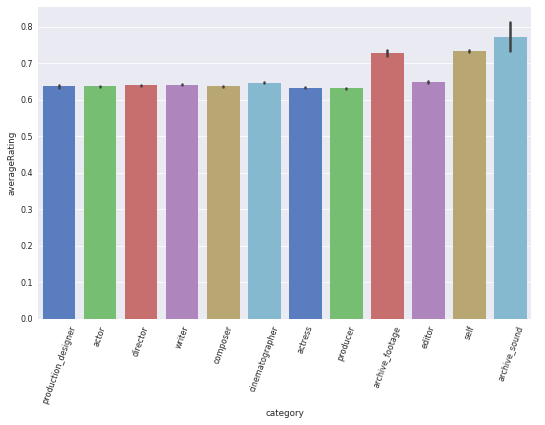

In [23]:
#ds_full = pd.read_csv('ds_full_reducido.csv')

#ds_full = pd.read_csv('ds_full_reducido.csv')
#df = ds_full[['tconst', 'category', 'nconst']]
#del ds_full

# Set up a factorplot
g = sns.factorplot("category", "averageRating", data=df,\
                   kind="bar", palette="muted", legend=False, aspect=1.5, size=5)
g.set_xticklabels(rotation=70)
g.add_legend()
# Show plot
plt.show()

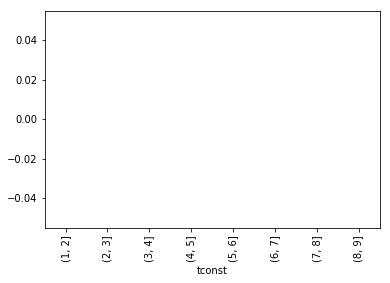

In [7]:
df_titles = ds_full[['tconst','averageRating']]
df_titles = df_titles.drop_duplicates()
df_titles = pd.to_numeric(df_titles['tconst'], errors='coerce')
df_titles.groupby(pd.cut(df_titles, np.arange(1,10,1))).count().plot.bar()

KeyboardInterrupt: 

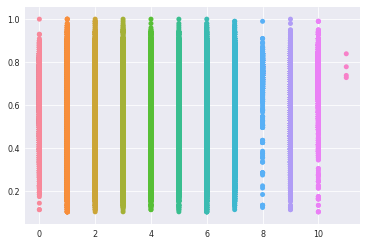

In [22]:
# Reset default params
sns.set()

# Set context to `"paper"`
sns.set_context("paper")


# Construct iris plot
sns.swarmplot(x="category", y="averageRating", data=df)

# Show plot
plt.show()

In [15]:
df = ds_full.copy()
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'titleType'])
df2 = df.groupby(['nconst', 'category'])['averageRating'].mean()
df2 = df2.unstack()

df3 = df.merge(df2, on='nconst')

In [16]:
df3['nconstAvgRolRating'] = 0
df3.loc[df3['category'] == 'actor', 'nconstAvgRolRating'] = df3['actor']
df3.loc[df3['category'] == 'actress', 'nconstAvgRolRating'] = df3['actress']
df3.loc[df3['category'] == 'archive_sound', 'nconstAvgRolRating'] = df3['archive_sound']
df3.loc[df3['category'] == 'cinematographer', 'nconstAvgRolRating'] = df3['cinematographer']
df3.loc[df3['category'] == 'composer', 'nconstAvgRolRating'] = df3['composer']
df3.loc[df3['category'] == 'editor', 'nconstAvgRolRating'] = df3['editor']
df3.loc[df3['category'] == 'director', 'nconstAvgRolRating'] = df3['director']
df3.loc[df3['category'] == 'producer', 'nconstAvgRolRating'] = df3['producer']
df3.loc[df3['category'] == 'production_designer', 'nconstAvgRolRating'] = df3['production_designer']
df3.loc[df3['category'] == 'self', 'nconstAvgRolRating'] = df3['self']
df3.loc[df3['category'] == 'writer', 'nconstAvgRolRating'] = df3['writer']
df3 = df3.drop(columns=['actor', 'actress', 'archive_footage','archive_sound', 'cinematographer', 'composer', 'editor', 'director', 'producer', 'production_designer', 'self', 'writer'])
df = df3

In [17]:
df['averageRating'] = df['averageRating'] / df['averageRating'].max()

In [18]:
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce') / pd.to_numeric(df['runtimeMinutes'], errors='coerce').max()

In [19]:
df['numVotes'] = df['numVotes'] / df['numVotes'].max()

In [20]:
df['nconstAvgRolRating'] = df['nconstAvgRolRating'] / df['nconstAvgRolRating'].max()

In [13]:
df2.sample(n=5)

## LA MAGIA
df2_copy = df2.T
df2_copy['nm0000001']['actor']
## vamos a dejar el dataframe de manera que cada rol tenga el avg del artista en todas sus peliculas para ese roll

category   actor   actress  archive_footage  archive_sound  cinematographer  \
nconst                                                                        
nm7995866    NaN       NaN              NaN            NaN              NaN   
nm6077431    NaN  5.900000              NaN            NaN              NaN   
nm1416513    NaN  7.400000              NaN            NaN              NaN   
nm0278557    NaN       NaN              NaN            NaN              6.8   
nm0005305    NaN  5.688889              NaN            NaN              NaN   

category   composer  director  editor  producer  production_designer  self  \
nconst                                                                       
nm7995866       NaN       NaN     NaN       7.6                  NaN   NaN   
nm6077431       NaN       NaN     NaN       NaN                  NaN   NaN   
nm1416513       NaN       NaN     NaN       NaN                  NaN   NaN   
nm0278557       NaN       NaN     NaN       NaN                  NaN   NaN   
nm0005305       NaN       NaN     NaN       NaN                  NaN   NaN   

category   writer  
nconst             
nm7995866     NaN  
nm6077431     NaN  
nm1416513     NaN  
nm0278557     NaN  
nm0005305     NaN

6.978125

In [21]:
ACTOR = 'actor'
ACTOR_1 = ACTOR + '1'
ACTOR_2 = ACTOR + '2'
ACTOR_3 = ACTOR + '3'
ACTOR_4 = ACTOR + '4'

ACTRESS = 'actress'
ACTRESS_1 = ACTRESS + '1'
ACTRESS_2 = ACTRESS + '2'
ACTRESS_3 = ACTRESS + '3'
ACTRESS_4 = ACTRESS + '4'

ARCHIVE_SOUND = 'archive_sound'
ARCHIVE_SOUND_1 = ARCHIVE_SOUND + '1'
ARCHIVE_SOUND_2 = ARCHIVE_SOUND + '2'
ARCHIVE_SOUND_3 = ARCHIVE_SOUND + '3'
ARCHIVE_SOUND_4 = ARCHIVE_SOUND + '4'

CINEMATOGRAPHER = 'cinematographer'
CINEMATOGRAPHER_1 = CINEMATOGRAPHER + '1'
CINEMATOGRAPHER_2 = CINEMATOGRAPHER + '2'
CINEMATOGRAPHER_3 = CINEMATOGRAPHER + '3'
CINEMATOGRAPHER_4 = CINEMATOGRAPHER + '4'

COMPOSER = 'composer'
COMPOSER_1 = COMPOSER + '1'
COMPOSER_2 = COMPOSER + '2'
COMPOSER_3 = COMPOSER + '3'
COMPOSER_4 = COMPOSER + '4'

DIRECTOR = 'director'
DIRECTOR_1 = DIRECTOR + '1'
DIRECTOR_2 = DIRECTOR + '2'
DIRECTOR_3 = DIRECTOR + '3'
DIRECTOR_4 = DIRECTOR + '4'

EDITOR = 'editor'
EDITOR_1 = EDITOR + '1'
EDITOR_2 = EDITOR + '2'
EDITOR_3 = EDITOR + '3'
EDITOR_4 = EDITOR + '4'

PRODUCER = 'producer'
PRODUCER_1 = PRODUCER + '1'
PRODUCER_2 = PRODUCER + '2'
PRODUCER_3 = PRODUCER + '3'
PRODUCER_4 = PRODUCER + '4'

PRODUCTION_DESIGNER = 'production_designer'
PRODUCTION_DESIGNER_1 = PRODUCTION_DESIGNER + '1'
PRODUCTION_DESIGNER_2 = PRODUCTION_DESIGNER + '2'
PRODUCTION_DESIGNER_3 = PRODUCTION_DESIGNER + '3'
PRODUCTION_DESIGNER_4 = PRODUCTION_DESIGNER + '4'

SELF = 'self'
SELF_1 = SELF + '1'
SELF_2 = SELF + '2'
SELF_3 = SELF + '3'
SELF_4 = SELF + '4'

WRITER = 'writer'
WRITER_1 = WRITER + '1'
WRITER_2 = WRITER + '2'
WRITER_3 = WRITER + '3'
WRITER_4 = WRITER + '4'

null_value = 'AAA'

df[ACTOR_1] = null_value
df[ACTOR_2] = null_value
df[ACTOR_3] = null_value
df[ACTOR_4] = null_value
df[ACTRESS_1] = null_value
df[ACTRESS_2] = null_value
df[ACTRESS_3] = null_value
df[ACTRESS_4] = null_value
df[ARCHIVE_SOUND_1] = null_value
df[ARCHIVE_SOUND_2] = null_value
df[ARCHIVE_SOUND_3] = null_value
df[ARCHIVE_SOUND_4] = null_value
df[CINEMATOGRAPHER_1] = null_value
df[CINEMATOGRAPHER_2] = null_value
df[CINEMATOGRAPHER_3] = null_value
df[CINEMATOGRAPHER_4] = null_value
df[COMPOSER_1] = null_value
df[COMPOSER_2] = null_value
df[COMPOSER_3] = null_value
df[COMPOSER_4] = null_value
df[DIRECTOR_1] = null_value
df[DIRECTOR_2] = null_value
df[DIRECTOR_3] = null_value
df[DIRECTOR_4] = null_value
df[EDITOR_1] = null_value
df[EDITOR_2] = null_value
df[EDITOR_3] = null_value
df[EDITOR_4] = null_value
df[PRODUCER_1] = null_value
df[PRODUCER_2] = null_value
df[PRODUCER_3] = null_value
df[PRODUCER_4] = null_value
df[PRODUCTION_DESIGNER_1] = null_value
df[PRODUCTION_DESIGNER_2] = null_value
df[PRODUCTION_DESIGNER_3] = null_value
df[PRODUCTION_DESIGNER_4] = null_value
df[SELF_1] = null_value
df[SELF_2] = null_value
df[SELF_3] = null_value
df[SELF_4] = null_value
df[WRITER_1] = null_value
df[WRITER_2] = null_value
df[WRITER_3] = null_value
df[WRITER_4] = null_value


In [22]:
temp = df.loc[:, ('tconst', 'nconst','category', \
           ACTOR_1,ACTOR_2,ACTOR_3,ACTOR_4, \
           DIRECTOR_1,DIRECTOR_2,DIRECTOR_3,DIRECTOR_4, \
           ACTRESS_1,ACTRESS_2,ACTRESS_3,ACTRESS_4, \
           ARCHIVE_SOUND_1,ARCHIVE_SOUND_2,ARCHIVE_SOUND_3,ARCHIVE_SOUND_4, \
           CINEMATOGRAPHER_1, CINEMATOGRAPHER_2, CINEMATOGRAPHER_3, CINEMATOGRAPHER_4, \
           COMPOSER_1,COMPOSER_2,COMPOSER_3,COMPOSER_4, \
           EDITOR_1,EDITOR_2,EDITOR_3,EDITOR_4, \
           PRODUCER_1,PRODUCER_2,PRODUCER_3,PRODUCER_4, \
           PRODUCTION_DESIGNER_1, PRODUCTION_DESIGNER_2, PRODUCTION_DESIGNER_3, PRODUCTION_DESIGNER_4, \
           SELF_1,SELF_2,SELF_3,SELF_4, \
           WRITER_1,WRITER_2,WRITER_3,WRITER_4)]
temp

tconst     nconst             category actor1 actor2 actor3 actor4  \
0       tt0002130  nm1376180  production_designer    AAA    AAA    AAA    AAA   
1       tt0002130  nm0660139                actor    AAA    AAA    AAA    AAA   
2       tt0002130  nm0685283                actor    AAA    AAA    AAA    AAA   
3       tt0002130  nm0209738                actor    AAA    AAA    AAA    AAA   
4       tt0002130  nm3942815                actor    AAA    AAA    AAA    AAA   
5       tt0002130  nm0078205             director    AAA    AAA    AAA    AAA   
6       tt0002130  nm0655824             director    AAA    AAA    AAA    AAA   
7       tt0002130  nm0019604               writer    AAA    AAA    AAA    AAA   
8       tt0026262  nm0019604               writer    AAA    AAA    AAA    AAA   
9       tt0089937  nm0019604               writer    AAA    AAA    AAA    AAA   
10      tt0479008  nm0019604               writer    AAA    AAA    AAA    AAA   
11      tt0002130  nm1374692             composer    AAA    AAA    AAA    AAA   
12      tt0002130  nm1376296      cinematographer    AAA    AAA    AAA    AAA   
13      tt0002423  nm0913298      cinematographer    AAA    AAA    AAA    AAA   
14      tt0002423  nm0624470              actress    AAA    AAA    AAA    AAA   
15      tt0011742  nm0624470              actress    AAA    AAA    AAA    AAA   
16      tt0011960  nm0624470              actress    AAA    AAA    AAA    AAA   
17      tt0058371  nm0624470              actress    AAA    AAA    AAA    AAA   
18      tt0002423  nm0417837                actor    AAA    AAA    AAA    AAA   
19      tt0014586  nm0417837                actor    AAA    AAA    AAA    AAA   
20      tt0015064  nm0417837                actor    AAA    AAA    AAA    AAA   
21      tt0016481  nm0417837                actor    AAA    AAA    AAA    AAA   
22      tt0016847  nm0417837                actor    AAA    AAA    AAA    AAA   
23      tt0019071  nm0417837                actor    AAA    AAA    AAA    AAA   
24      tt0020697  nm0417837                actor    AAA    AAA    AAA    AAA   
25      tt3565328  nm0417837                actor    AAA    AAA    AAA    AAA   
26      tt0002423  nm0509573                actor    AAA    AAA    AAA    AAA   
27      tt0009893  nm0509573                actor    AAA    AAA    AAA    AAA   
28      tt0014900  nm0509573                actor    AAA    AAA    AAA    AAA   
29      tt0002423  nm0903235                actor    AAA    AAA    AAA    AAA   
...           ...        ...                  ...    ...    ...    ...    ...   
373905  tt8005366  nm6717263                actor    AAA    AAA    AAA    AAA   
373906  tt8005366  nm7352558               writer    AAA    AAA    AAA    AAA   
373907  tt8005366  nm8594112               writer    AAA    AAA    AAA    AAA   
373908  tt8005366  nm5131788             producer    AAA    AAA    AAA    AAA   
373909  tt8024712  nm8662914                actor    AAA    AAA    AAA    AAA   
373910  tt8024712  nm5143618              actress    AAA    AAA    AAA    AAA   
373911  tt8024712  nm7646570                actor    AAA    AAA    AAA    AAA   
373912  tt8024712  nm1235505                actor    AAA    AAA    AAA    AAA   
373913  tt8024712  nm3160391             director    AAA    AAA    AAA    AAA   
373914  tt8024712  nm7919191               writer    AAA    AAA    AAA    AAA   
373915  tt8024712  nm9103082               writer    AAA    AAA    AAA    AAA   
373916  tt8024712  nm2726089             producer    AAA    AAA    AAA    AAA   
373917  tt8080556  nm2237150                 self    AAA    AAA    AAA    AAA   
373918  tt8080556  nm0160577                 self    AAA    AAA    AAA    AAA   
373919  tt8080556  nm2010047               writer    AAA    AAA    AAA    AAA   
373920  tt8081062  nm7010941      archive_footage    AAA    AAA    AAA    AAA   
373921  tt8081062  nm2863763             director    AAA    AAA    AAA    AAA   
373922  tt8106570  nm9818234              

In [23]:
for idx, data in temp.iterrows():
    tconst = data['tconst']
    mask = (temp.tconst == tconst)
    nconst = data['nconst']
    print(idx)
    if data['category'] == ACTOR:
        if data[ACTOR_1] == null_value:
            temp.loc[mask, (ACTOR_1)] = nconst
        elif data[ACTOR_2] == null_value:
            temp.loc[mask, (ACTOR_2)] = nconst
        elif data[ACTOR_3] == null_value:
            temp.loc[mask, (ACTOR_3)] = nconst
        elif data[ACTOR_4] == null_value:
            temp.loc[mask, (ACTOR_4)] = nconst
        else:
            pass
    elif data['category'] == DIRECTOR:
        if data[DIRECTOR_1] == null_value:
            temp.loc[mask, (DIRECTOR_1)] = nconst
        elif data[DIRECTOR_2] == null_value:
            temp.loc[mask, (DIRECTOR_2)] = nconst
        elif data[DIRECTOR_3] == null_value:
            temp.loc[mask, (DIRECTOR_3)] = nconst
        elif data[DIRECTOR_4] == null_value:
            temp.loc[mask, (DIRECTOR_4)] = nconst
        else:
            pass
    elif data['category'] == ACTRESS:
        if data[ACTRESS_1] == null_value:
            temp.loc[mask, (ACTRESS_1)] = nconst
        elif data[ACTRESS_2] == null_value:
            temp.loc[mask, (ACTRESS_2)] = nconst
        elif data[ACTRESS_3] == null_value:
            temp.loc[mask, (ACTRESS_3)] = nconst
        elif data[ACTRESS_4] == null_value:
            temp.loc[mask, (ACTRESS_4)] = nconst
        else:
            pass
    elif data['category'] == ARCHIVE_SOUND:
        if data[ARCHIVE_SOUND_1] == null_value:
            temp.loc[mask, (ARCHIVE_SOUND_1)] = nconst
        elif data[ARCHIVE_SOUND_2] == null_value:
            temp.loc[mask, (ARCHIVE_SOUND_2)] = nconst
        elif data[ARCHIVE_SOUND_3] == null_value:
            temp.loc[mask, (ARCHIVE_SOUND_3)] = nconst
        elif data[ARCHIVE_SOUND_4] == null_value:
            temp.loc[mask, (ARCHIVE_SOUND_4)] = nconst
        else:
            pass
    elif data['category'] == CINEMATOGRAPHER:
        if data[CINEMATOGRAPHER_1] == null_value:
            temp.loc[mask, (CINEMATOGRAPHER_1)] = nconst
        elif data[CINEMATOGRAPHER_2] == null_value:
            temp.loc[mask, (CINEMATOGRAPHER_2)] = nconst
        elif data[CINEMATOGRAPHER_3] == null_value:
            temp.loc[mask, (CINEMATOGRAPHER_3)] = nconst
        elif data[CINEMATOGRAPHER_4] == null_value:
            temp.loc[mask, (CINEMATOGRAPHER_4)] = nconst
        else:
            pass
    elif data['category'] == COMPOSER:
        if data[COMPOSER_1] == null_value:
            temp.loc[mask, (COMPOSER_1)] = nconst
        elif data[COMPOSER_2] == null_value:
            temp.loc[mask, (COMPOSER_2)] = nconst
        elif data[COMPOSER_3] == null_value:
            temp.loc[mask, (COMPOSER_3)] = nconst
        elif data[COMPOSER_4] == null_value:
            temp.loc[mask, (COMPOSER_4)] = nconst
        else:
            pass
    elif data['category'] == EDITOR:
        if data[EDITOR_1] == null_value:
            temp.loc[mask, (EDITOR_1)] = nconst
        elif data[EDITOR_2] == null_value:
            temp.loc[mask, (EDITOR_2)] = nconst
        elif data[EDITOR_3] == null_value:
            temp.loc[mask, (EDITOR_3)] = nconst
        elif data[EDITOR_4] == null_value:
            temp.loc[mask, (EDITOR_4)] = nconst
        else:
            pass
    elif data['category'] == PRODUCER:
        if data[PRODUCER_1] == null_value:
            temp.loc[mask, (PRODUCER_1)] = nconst
        elif data[PRODUCER_2] == null_value:
            temp.loc[mask, (PRODUCER_2)] = nconst
        elif data[PRODUCER_3] == null_value:
            temp.loc[mask, (PRODUCER_3)] = nconst
        elif data[PRODUCER_4] == null_value:
            temp.loc[mask, (PRODUCER_4)] = nconst
        else:
            pass
    elif data['category'] == PRODUCTION_DESIGNER:
        if data[PRODUCTION_DESIGNER_1] == null_value:
            temp.loc[mask, (PRODUCTION_DESIGNER_1)] = nconst
        elif data[PRODUCTION_DESIGNER_2] == null_value:
            temp.loc[mask, (PRODUCTION_DESIGNER_2)] = nconst
        elif data[PRODUCTION_DESIGNER_3] == null_value:
            temp.loc[mask, (PRODUCTION_DESIGNER_3)] = nconst
        elif data[PRODUCTION_DESIGNER_4] == null_value:
            temp.loc[mask, (PRODUCTION_DESIGNER_4)] = nconst
        else:
            pass
    elif data['category'] == SELF:
        if data[SELF_1] == null_value:
            temp.loc[mask, (SELF_1)] = nconst
        elif data[SELF_2] == null_value:
            temp.loc[mask, (SELF_2)] = nconst
        elif data[SELF_3] == null_value:
            temp.loc[mask, (SELF_3)] = nconst
        elif data[SELF_4] == null_value:
            temp.loc[mask, (SELF_4)] = nconst
        else:
            pass
    elif data['category'] == WRITER:
        if data[WRITER_1] == null_value:
            temp.loc[mask, (WRITER_1)] = nconst
        elif data[WRITER_2] == null_value:
            temp.loc[mask, (WRITER_2)] = nconst
        elif data[WRITER_3] == null_value:
            temp.loc[mask, (WRITER_3)] = nconst
        elif data[WRITER_4] == null_value:
            temp.loc[mask, (WRITER_4)] = nconst
        else:
            pass
    
temp

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704


KeyboardInterrupt: 

In [3]:
ds_full

Unnamed: 0     tconst                               primaryTitle  \
0                0  tt0002130                            Dante's Inferno   
1                1  tt0002130                            Dante's Inferno   
2                2  tt0002130                            Dante's Inferno   
3                3  tt0002130                            Dante's Inferno   
4                4  tt0002130                            Dante's Inferno   
5                5  tt0002130                            Dante's Inferno   
6                6  tt0002130                            Dante's Inferno   
7                7  tt0002130                            Dante's Inferno   
8                8  tt0002130                            Dante's Inferno   
9                9  tt0002130                            Dante's Inferno   
10              10  tt0002423                             Madame DuBarry   
11              11  tt0002423                             Madame DuBarry   
12              12  tt0002423                             Madame DuBarry   
13              13  tt0002423                             Madame DuBarry   
14              14  tt0002423                             Madame DuBarry   
15              15  tt0002423                             Madame DuBarry   
16              16  tt0002423                             Madame DuBarry   
17              17  tt0002423                             Madame DuBarry   
18              18  tt0002423                             Madame DuBarry   
19              19  tt0002423                             Madame DuBarry   
20              20  tt0002844  Fantômas: In the Shadow of the Guillotine   
21              21  tt0002844  Fantômas: In the Shadow of the Guillotine   
22              22  tt0002844  Fantômas: In the Shadow of the Guillotine   
23              23  tt0002844  Fantômas: In the Shadow of the Guillotine   
24              24  tt0002844  Fantômas: In the Shadow of the Guillotine   
25              25  tt0002844  Fantômas: In the Shadow of the Guillotine   
26              26  tt0002844  Fantômas: In the Shadow of the Guillotine   
27              27  tt0002844  Fantômas: In the Shadow of the Guillotine   
28              28  tt0002844  Fantômas: In the Shadow of the Guillotine   
29              29  tt0002844  Fantômas: In the Shadow of the Guillotine   
...            ...        ...                                        ...   
373905      373905  tt8080556                  The Director and The Jedi   
373906      373906  tt8081062                              Amazing China   
373907      373907  tt8081062                              Amazing China   
373908      373908  tt8106570                          The Rachel Divide   
373909      373909  tt8106570                          The Rachel Divide   
373910      373910  tt8106570                          The Rachel Divide   
373911      373911  tt8106570                          The Rachel Divide   
373912      373912  tt8106570                          The Rachel Divide   
373913      373913  tt8106570                          The Rachel Divide   
373914      373914  tt8106570                          The Rachel Divide   
373915      373915  tt8106570                          The Rachel Divide   
373916      373916  tt8106570                          The Rachel Divide   
373917      373917  tt8335880                                     Loro 2   
373918      373918  tt8335880                                     Loro 2   
373919      373919  tt8335880                                     Loro 2   
373920      373920  tt8335880                                     Loro 2   
373921      373921  tt8335880                                     Loro 2   
373922      373922  tt8335880                                     Loro 2   
373923      373923  tt8335880                                     Loro 2   
373924      373924  tt8335880                                     Loro 2   
373925      373925  tt8335880                           

In [25]:
temp

tconst     nconst             category     actor1     actor2  \
0       tt0002130  nm1376180  production_designer  nm0660139  nm0685283   
1       tt0002130  nm0660139                actor  nm0660139  nm0685283   
2       tt0002130  nm0685283                actor  nm0660139  nm0685283   
3       tt0002130  nm0209738                actor  nm0660139  nm0685283   
4       tt0002130  nm3942815                actor  nm0660139  nm0685283   
5       tt0002130  nm0078205             director  nm0660139  nm0685283   
6       tt0002130  nm0655824             director  nm0660139  nm0685283   
7       tt0002130  nm0019604               writer  nm0660139  nm0685283   
8       tt0026262  nm0019604               writer  nm0910400        AAA   
9       tt0089937  nm0019604               writer        AAA        AAA   
10      tt0479008  nm0019604               writer        AAA        AAA   
11      tt0002130  nm1374692             composer  nm0660139  nm0685283   
12      tt0002130  nm1376296      cinematographer  nm0660139  nm0685283   
13      tt0002423  nm0913298      cinematographer  nm0417837  nm0509573   
14      tt0002423  nm0624470              actress  nm0417837  nm0509573   
15      tt0011742  nm0624470              actress  nm0523932  nm0917467   
16      tt0011960  nm0624470              actress  nm0418131  nm0858164   
17      tt0058371  nm0624470              actress        AAA        AAA   
18      tt0002423  nm0417837                actor  nm0417837  nm0509573   
19      tt0014586  nm0417837                actor  nm0417837  nm0891998   
20      tt0015064  nm0417837                actor  nm0417837  nm0384897   
21      tt0016481  nm0417837                actor  nm0417837        AAA   
22      tt0016847  nm0417837                actor  nm0417837        AAA   
23      tt0019071  nm0417837                actor  nm0417837        AAA   
24      tt0020697  nm0417837                actor  nm0417837        AAA   
25      tt3565328  nm0417837                actor  nm0417837        AAA   
26      tt0002423  nm0509573                actor  nm0417837  nm0509573   
27      tt0009893  nm0509573                actor  nm0509573  nm0418131   
28      tt0014900  nm0509573                actor  nm0509573  nm0002154   
29      tt0002423  nm0903235                actor  nm0417837  nm0509573   
...           ...        ...                  ...        ...        ...   
373905  tt8005366  nm6717263                actor        AAA        AAA   
373906  tt8005366  nm7352558               writer        AAA        AAA   
373907  tt8005366  nm8594112               writer        AAA        AAA   
373908  tt8005366  nm5131788             producer        AAA        AAA   
373909  tt8024712  nm8662914                actor        AAA        AAA   
373910  tt8024712  nm5143618              actress        AAA        AAA   
373911  tt8024712  nm7646570                actor        AAA        AAA   
373912  tt8024712  nm1235505                actor        AAA        AAA   
373913  tt8024712  nm3160391             director        AAA        AAA   
373914  tt8024712  nm7919191               writer        AAA        AAA   
373915  tt8024712  nm9103082               writer        AAA        AAA   
373916  tt8024712  nm2726089             producer        AAA        AAA   
373917  tt8080556  nm2237150                 self        AAA        AAA   
373918  tt8080556  nm0160577                 self        AAA        AAA   
373919  tt8080556  nm2010047               writer        AAA        AAA   
373920  tt8081062  nm7010941      archive_footage        AAA        AAA   
373921  tt8081062  nm2863763             director        AAA        AAA   
373922  tt8106570  nm9818234                 self        AAA        AAA   
373923  tt8106570  nm9818233                 self        AAA        AAA   
373924  tt8106570  nm7390131                 self        AAA        AAA   
373925  tt8106570  nm0115269             director        AAA        AAA   
373926  tt8106570  nm2290785        

In [30]:
for name, group in df_grouped: 
    print('group: artist ')
    print(group)

ValueError: too many values to unpack (expected 2)

In [37]:
# Draw a count plot to show the number of planets discovered each year

g = sns.factorplot(x="averageRating", data=df_grouped, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

AttributeError: Cannot access callable attribute 'get' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [10]:
df.loc[df['category'] == 'director', 'category'] = 2

In [11]:
df['category'].unique()

array(['production_designer', 'actor', 2, 'writer', 'composer',
       'cinematographer', 'actress', 'producer', 'editor', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [30]:
df['numVotes'].percentil([0.1, 0.2, 0.3, 0.4, 0.8])

AttributeError: 'Series' object has no attribute 'percentil'

In [52]:
# promedio del average de cada pelicula de esa persona en ese rol
df['numVotesBand'] = pd.cut(df['numVotes'], 20)

In [53]:
df.numVotesBand.unique()

[(-0.000743, 0.0502], (0.0502, 0.1], (0.1, 0.15], (0.15, 0.2], (0.2, 0.25], ..., (0.6, 0.65], (0.7, 0.75], (0.8, 0.85], (0.55, 0.6], (0.85, 0.9]]
Length: 19
Categories (19, interval[float64]): [(-0.000743, 0.0502] < (0.0502, 0.1] < (0.1, 0.15] < (0.15, 0.2] ... (0.75, 0.8] < (0.8, 0.85] < (0.85, 0.9] < (0.95, 1.0]]

In [ ]:
df['numVotesTag'] = 0

df.loc[df['numVotesBand'] < 5]